# Dataset Exploration

## Setup and Configuration

In [ ]:
import os
import torch
import textwrap
import numpy as np
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.lines import Line2D
from ogb.nodeproppred import NodePropPredDataset

import warnings
warnings.filterwarnings("ignore", module='outdated')
warnings.filterwarnings("ignore", message=".*weights_only=False.*")

c:\Users\Tulio\AppData\Local\Programs\Python\Python311\Lib\site-packages\outdated\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
data_dir = '../dataset' # Relative path from the project root
ogb_root = os.path.join(data_dir, 'ogbn_arxiv')

# Ensure the 'dataset' directory exists
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Directory '{data_dir}' created.")

## Load Dataset

In [3]:
dataset = NodePropPredDataset(name='ogbn-arxiv', root=data_dir)

In [4]:
# Extract graph, labels, and splits
graph, labels = dataset[0]
node_features = graph['node_feat'] # Node features
num_nodes = graph['num_nodes']
edge_index = graph['edge_index']
num_edges = edge_index.shape[1]

In [5]:
split_idx = dataset.get_idx_split()

train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx = split_idx["test"]

In [6]:
print(f"\n--- Dataset Splits ---")
print(f"Train (up to 2017): {len(train_idx)} nodes")
print(f"Validation (2018): {len(valid_idx)} nodes")
print(f"Test (2019+): {len(test_idx)} nodes")


--- Dataset Splits ---
Train (up to 2017): 90941 nodes
Validation (2018): 29799 nodes
Test (2019+): 48603 nodes


## Load Mapping Files

In [7]:
# Load category mapping (label index to category name)
label_map_path = os.path.join(ogb_root, 'mapping', 'labelidx2arxivcategeory.csv.gz')
label_map_df = pd.read_csv(label_map_path, compression='gzip', skiprows=1, header=None, names=['label_idx', 'category_name'])
label_map = dict(zip(label_map_df.label_idx, label_map_df.category_name))
list(label_map.items())[:5]

[(0, 'arxiv cs na'),
 (1, 'arxiv cs mm'),
 (2, 'arxiv cs lo'),
 (3, 'arxiv cs cy'),
 (4, 'arxiv cs cr')]

In [8]:
# Load node index to paper ID mapping
node_map_path = os.path.join(ogb_root, 'mapping', 'nodeidx2paperid.csv.gz')
node_map_df = pd.read_csv(node_map_path, compression='gzip', skiprows=1, header=None, names=['node_idx', 'paper_id'])
node2paperid = dict(zip(node_map_df.node_idx, node_map_df.paper_id))
list(node2paperid.items())[:5]

[(0, 9657784), (1, 39886162), (2, 116214155), (3, 121432379), (4, 231147053)]

In [9]:
# Load paper ID to title/abstract mapping
titleabs_path = os.path.join(ogb_root, 'titleabs.tsv')
titleabs_df = pd.read_csv(titleabs_path, sep='\t', header=None, names=['paper_id', 'title', 'abstract'])
paperid2title = dict(zip(titleabs_df.paper_id, titleabs_df.title))
list(paperid2title.items())[:5]

[(200971, 'ontology as a source for rule generation'),
 (549074,
  'a novel methodology for thermal analysis a 3 dimensional memory integration'),
 (630234, 'spreadsheets on the move an evaluation of mobile spreadsheets'),
 (803423, 'multi view metric learning for multi view video summarization'),
 (1102481, 'big data analytics in future internet of things')]

## Exploratory Graph Analysis

In [10]:
# Number of nodes and edges
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Feature dimensions: {node_features.shape}")
print(f"Label dimensions: {labels.shape}")

Number of nodes: 169343
Number of edges: 1166243
Feature dimensions: (169343, 128)
Label dimensions: (169343, 1)


In [11]:
# Label distribution with category names
print("\nLabel Distribution:")
unique_labels, counts = np.unique(labels, return_counts=True)
# Map label indices to names for printing and plotting
named_counts = {label_map[label]: count for label, count in zip(unique_labels, counts)}
sorted_named_labels = sorted(named_counts.items(), key=lambda item: item[1], reverse=True)

# Print the 10 most frequent classes
for i, (name, count) in enumerate(sorted_named_labels[:10]):
    print(f"  {name}: {count} samples")


Label Distribution:
  arxiv cs cv: 27321 samples
  arxiv cs lg: 22187 samples
  arxiv cs it: 21406 samples
  arxiv cs cl: 11814 samples
  arxiv cs ai: 7869 samples
  arxiv cs ds: 7867 samples
  arxiv cs ni: 6232 samples
  arxiv cs cr: 5862 samples
  arxiv cs dc: 4958 samples
  arxiv cs lo: 4839 samples


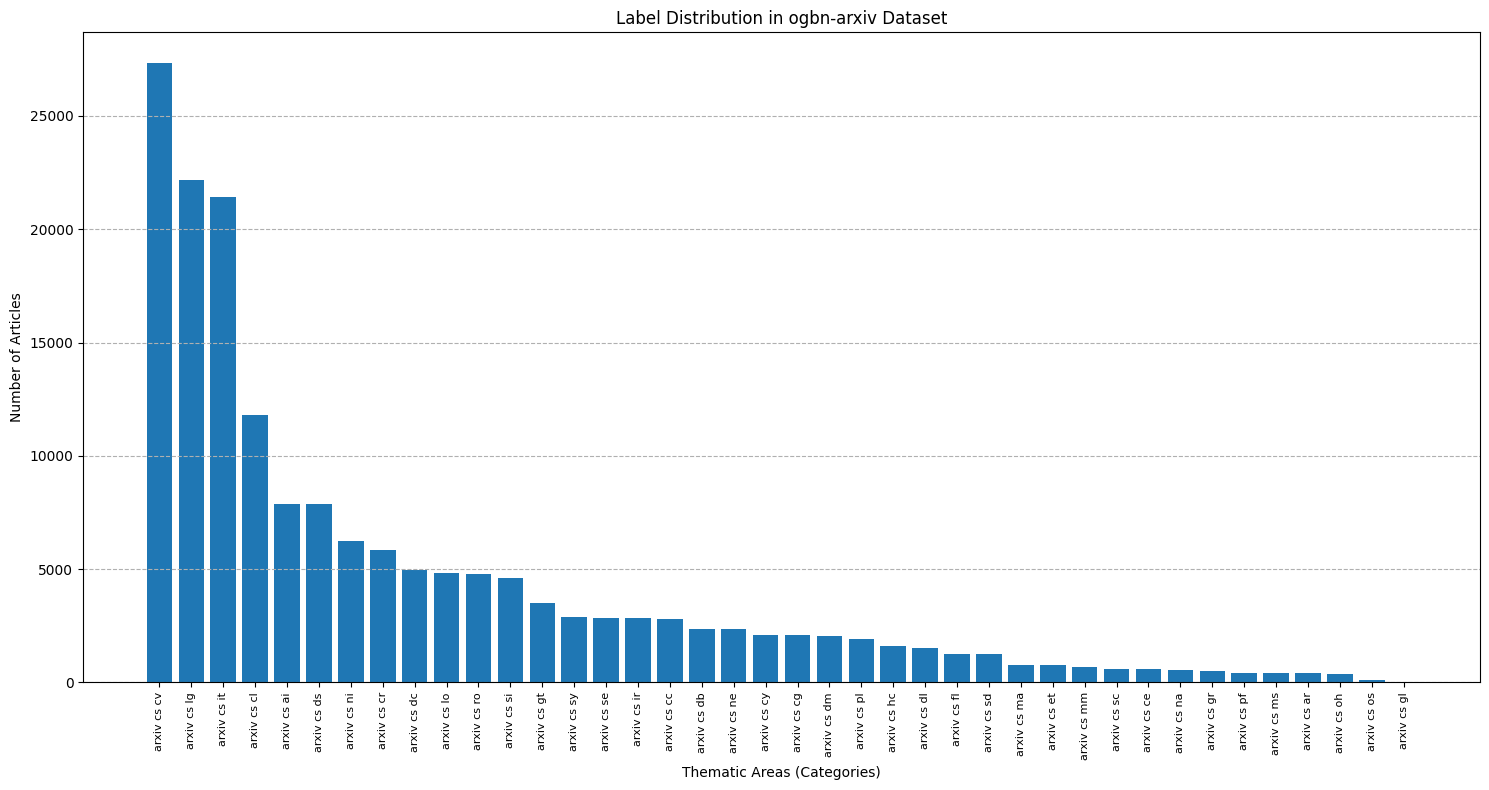

In [12]:
sorted_names, sorted_counts = zip(*sorted_named_labels)

# Plotting label distribution
plt.figure(figsize=(15, 8))
plt.bar(sorted_names, sorted_counts)
plt.xlabel("Thematic Areas (Categories)")
plt.ylabel("Number of Articles")
plt.title("Label Distribution in ogbn-arxiv Dataset")
plt.xticks(rotation=90, fontsize=8) # Rotação ajuda a ler os nomes
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [13]:
# Basic statistics of node embeddings
print("\nNode Embedding Statistics:")
print(f"  Shape of embeddings: {node_features.shape}")
print(f"  Minimum value: {node_features.min():.4f}")
print(f"  Maximum value: {node_features.max():.4f}")
print(f"  Mean: {node_features.mean():.4f}")
print(f"  Standard deviation: {node_features.std():.4f}")


Node Embedding Statistics:
  Shape of embeddings: (169343, 128)
  Minimum value: -1.3889
  Maximum value: 1.6387
  Mean: 0.0205
  Standard deviation: 0.2332


## Graph Visualization

In [14]:
def visualize_ego_graph(target_node_id, edge_index, labels, label_map, 
                        node2paperid, paperid2title, max_nodes=100):
    """
    Visualizes the ego-graph (subgraph) around a specific node.
    
    Parameters:
    - target_node_id: The integer index of the node to visualize.
    - edge_index: The edge index tensor/array of the graph (2, num_edges).
    - labels: Array of node labels.
    - label_map: Dictionary mapping label indices to category names.
    - node2paperid: Dictionary mapping node indices to MAG Paper IDs.
    - paperid2title: Dictionary mapping MAG Paper IDs to Titles.
    - max_nodes: Maximum number of nodes to display (to avoid clutter).
    """
    
    # 1. Calculate Degrees (Connections)
    src, dst = edge_index[0], edge_index[1]
    
    in_degree = np.sum(dst == target_node_id)   # How many cite this paper
    out_degree = np.sum(src == target_node_id)  # How many this paper cites
    total_connections = in_degree + out_degree

    print(f"--- Node Analysis ---")
    print(f"Target Node: {target_node_id}")
    print(f"In-Degree (Citations Received): {in_degree}")
    print(f"Out-Degree (References Made): {out_degree}")
    print(f"Total Connections: {total_connections}")

    # 2. Subgraph Sampling
    # Find neighbors (either source or destination is the target)
    neighbor_mask = (src == target_node_id) | (dst == target_node_id)
    
    # Get unique neighbors
    direct_neighbors = np.unique(np.concatenate((src[neighbor_mask], dst[neighbor_mask])))
    
    # Remove the target node itself from neighbors list to handle sampling
    direct_neighbors = direct_neighbors[direct_neighbors != target_node_id]
    
    # If too many neighbors, sample randomly
    if len(direct_neighbors) > (max_nodes - 1):
        rng = np.random.default_rng(42)
        direct_neighbors = rng.choice(direct_neighbors, size=(max_nodes - 1), replace=False)
        print(f"Note: Subgraph sampled to {max_nodes} nodes (original neighbors: {len(direct_neighbors) + 1})")

    # Combine target and neighbors
    nodes_in_subgraph = np.append(direct_neighbors, target_node_id)
    
    # Filter edges to keep only those connecting nodes within this subgraph
    mask_sub = np.isin(src, nodes_in_subgraph) & np.isin(dst, nodes_in_subgraph)
    subset_src = src[mask_sub]
    subset_dst = dst[mask_sub]

    # 3. Retrieve Metadata
    try:
        center_mag_id = node2paperid[target_node_id]
        center_title = paperid2title.get(center_mag_id, "Title not found in mapping")
    except KeyError:
        center_title = "Metadata not found"
        
    center_cat_idx = labels[target_node_id].item()
    center_category = label_map[center_cat_idx]

    # 4. Prepare NetworkX Graph
    G = nx.DiGraph()
    G.add_nodes_from(nodes_in_subgraph)
    G.add_edges_from(list(zip(subset_src, subset_dst)))

    # Colors setup (using a professional palette)
    subgraph_labels = labels[nodes_in_subgraph].flatten()
    unique_sub_labels = np.unique(subgraph_labels)
    cmap = plt.get_cmap("tab10") 
    color_map_dict = {label: cmap(i % 10) for i, label in enumerate(unique_sub_labels)}
    
    node_colors = [color_map_dict[labels[n].item()] for n in G.nodes()]
    
    # Sizes: Target node is larger
    node_sizes = [1500 if n == target_node_id else 300 for n in G.nodes()]

    # 5. Plotting
    plt.figure(figsize=(16, 10), facecolor='white')
    
    # Layout with repulsion (k)
    pos = nx.spring_layout(G, seed=42, k=1.5, iterations=100)

    # Draw Edges (Curved)
    nx.draw_networkx_edges(G, pos, 
                           edge_color='lightgray', 
                           alpha=0.6, 
                           arrows=True, 
                           arrowstyle='-|>', 
                           arrowsize=15, 
                           width=1.5,
                           connectionstyle="arc3,rad=0.1")

    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, 
                           nodelist=G.nodes(),
                           node_size=node_sizes, 
                           node_color=node_colors, 
                           alpha=0.9,
                           edgecolors='white', 
                           linewidths=2)

    # Draw Label for Target Node Only
    nx.draw_networkx_labels(G, pos, labels={target_node_id: str(target_node_id)}, 
                            font_size=12, font_weight='bold', font_color='white')

    # 6. Information Card (Text Box)
    info_text = (f"NODE ID: {target_node_id}\n"
                 f"IN-DEGREE: {in_degree}\n"
                 f"OUT-DEGREE: {out_degree}\n"
                 f"CATEGORY: {center_category}\n"
                 f"{'-'*25}\n"
                 f"TITLE:\n{textwrap.fill(center_title, width=35)}")

    plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.8', facecolor='#f8f9fa', alpha=0.9, edgecolor='#dee2e6'))

    # 7. Legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label_map[lbl],
                              markerfacecolor=color, markersize=10)
                       for lbl, color in color_map_dict.items()]

    plt.legend(handles=legend_elements, title="Research Fields", 
               loc='lower right', frameon=True, framealpha=0.9, fontsize=10)

    plt.title(f"Ego-Graph Visualization: Node {target_node_id}", fontsize=16, weight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

--- Selection Summary ---
Top 3 Most Cited Nodes: [ 1353 67166 25208] (Citations: [13155 12527  9244])
Least Cited Node: 84477 (Citations: 1)
-------------------------

Generating Graph for Node 1353 (#1 Most Cited)...
--- Node Analysis ---
Target Node: 1353
In-Degree (Citations Received): 13155
Out-Degree (References Made): 6
Total Connections: 13161
Note: Subgraph sampled to 100 nodes (original neighbors: 100)


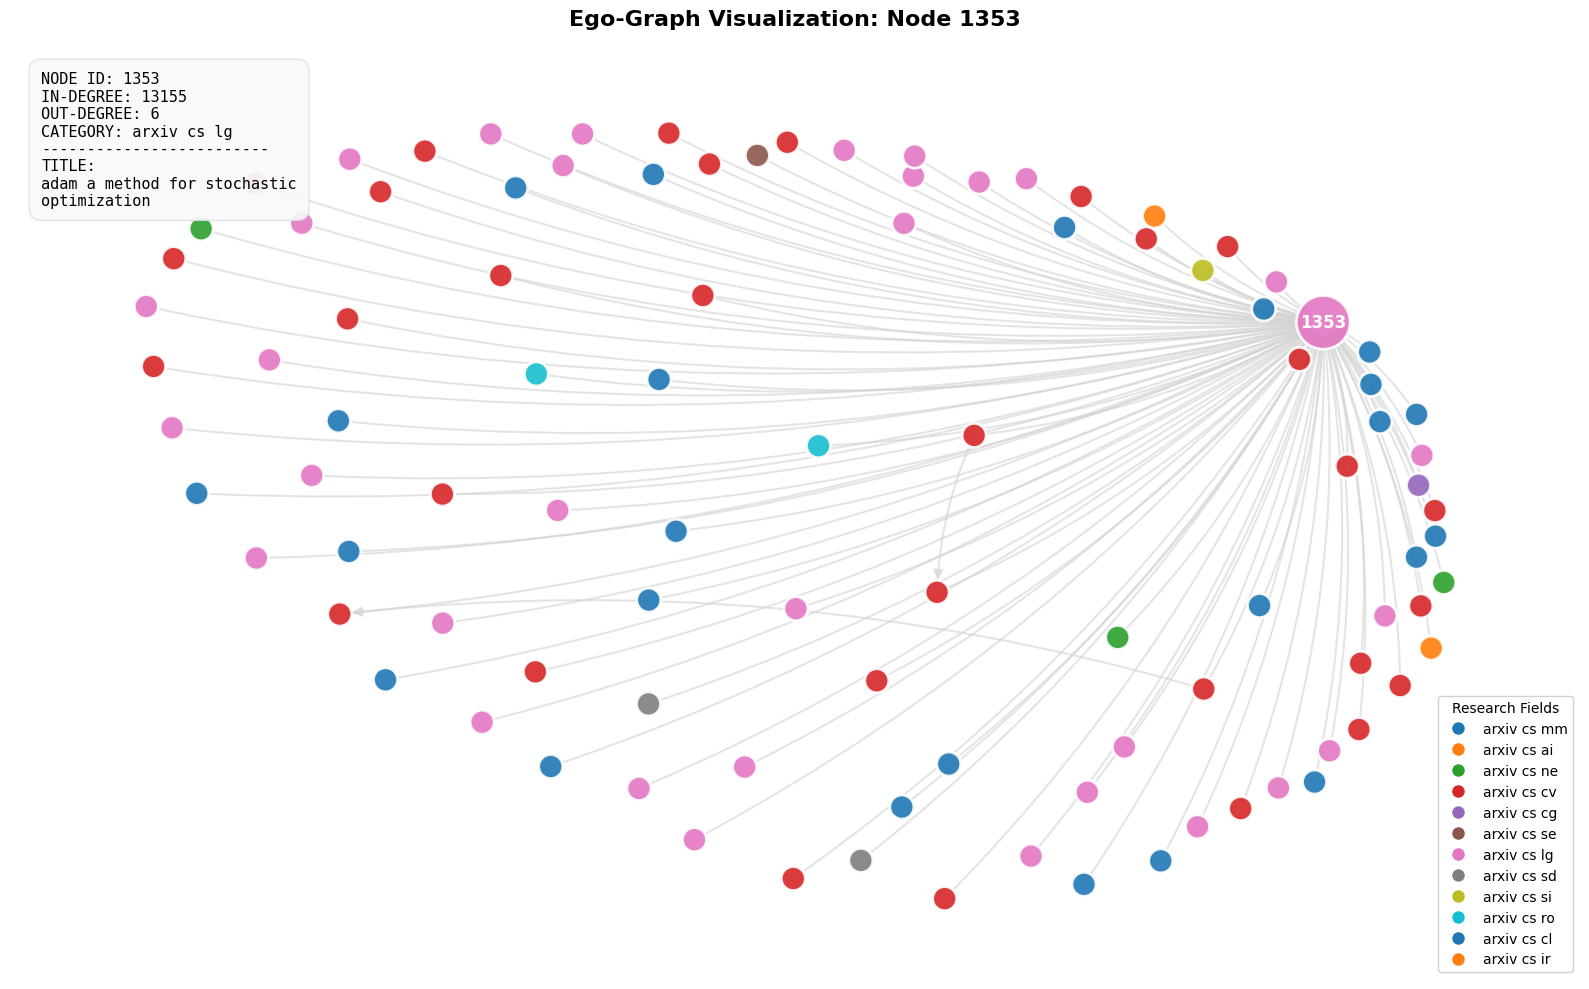

Generating Graph for Node 67166 (#2 Most Cited)...
--- Node Analysis ---
Target Node: 67166
In-Degree (Citations Received): 12527
Out-Degree (References Made): 21
Total Connections: 12548
Note: Subgraph sampled to 100 nodes (original neighbors: 100)


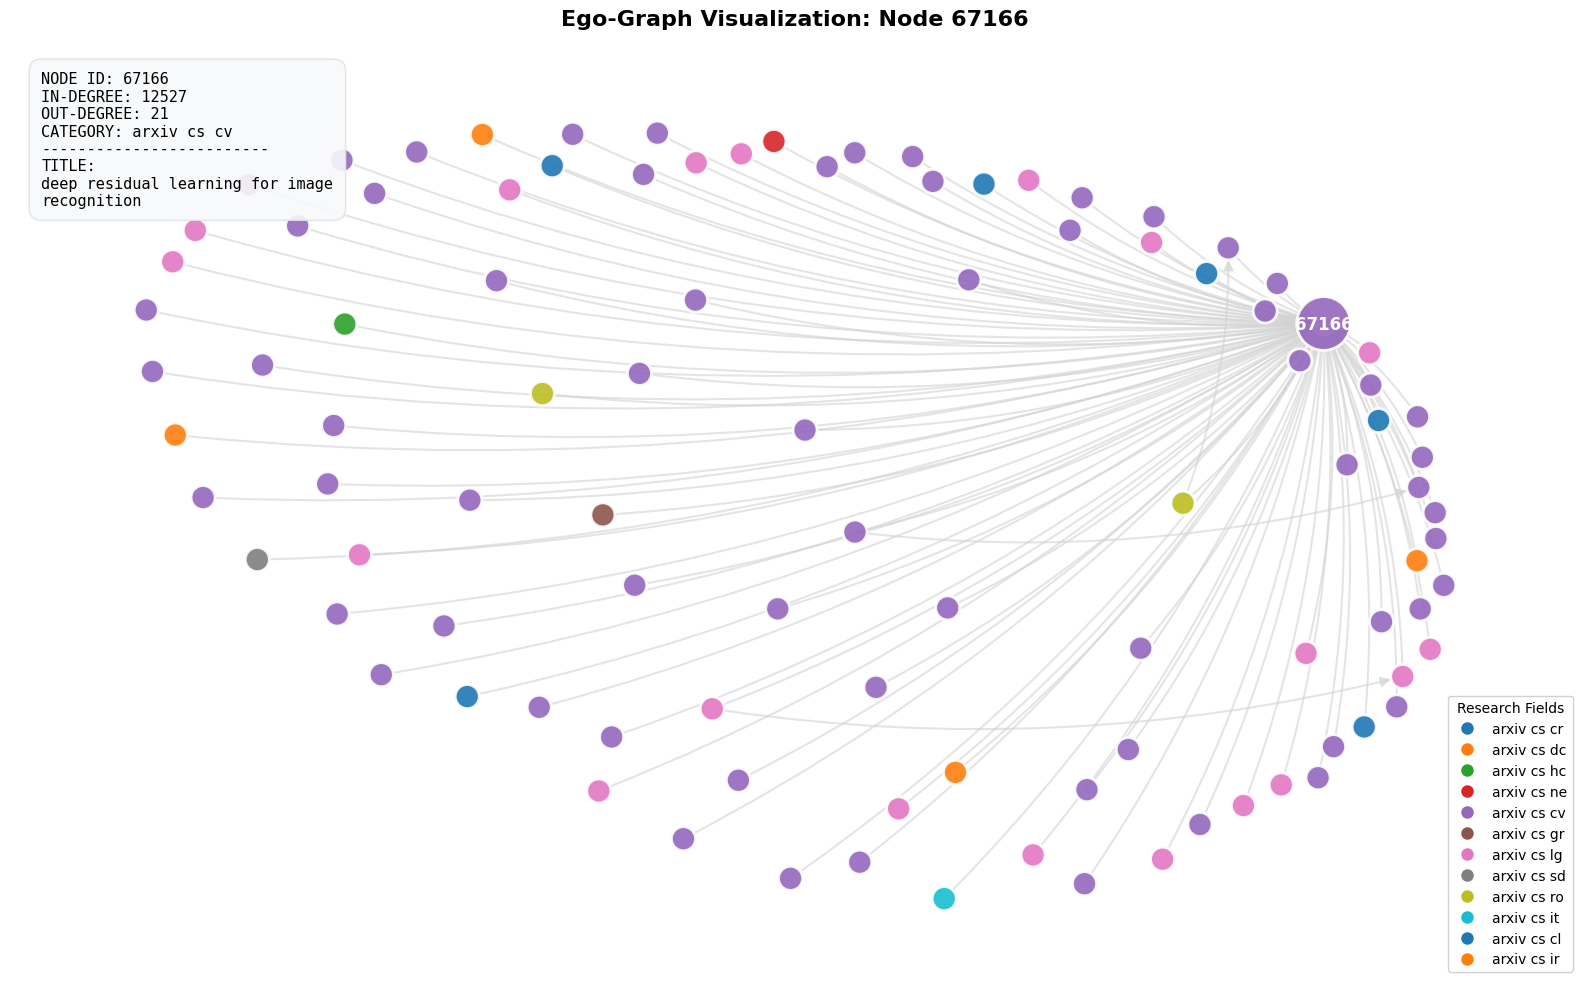

Generating Graph for Node 25208 (#3 Most Cited)...
--- Node Analysis ---
Target Node: 25208
In-Degree (Citations Received): 9244
Out-Degree (References Made): 21
Total Connections: 9265
Note: Subgraph sampled to 100 nodes (original neighbors: 100)


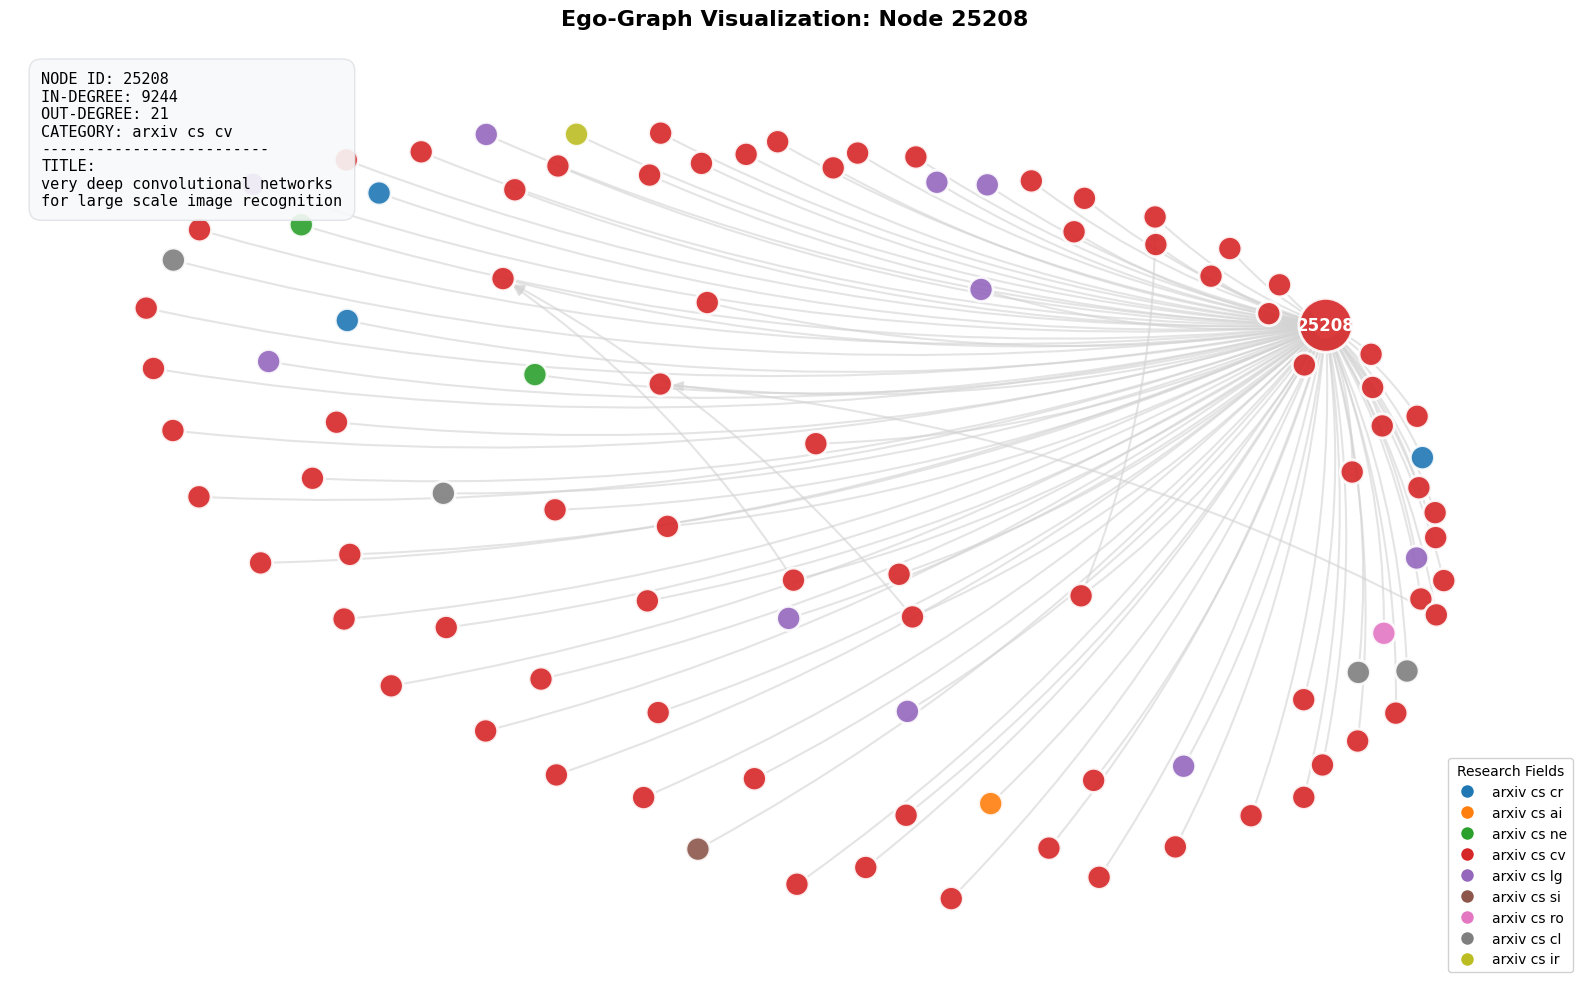

Generating Graph for Node 84477 (Least Cited (Example))...
--- Node Analysis ---
Target Node: 84477
In-Degree (Citations Received): 1
Out-Degree (References Made): 5
Total Connections: 6


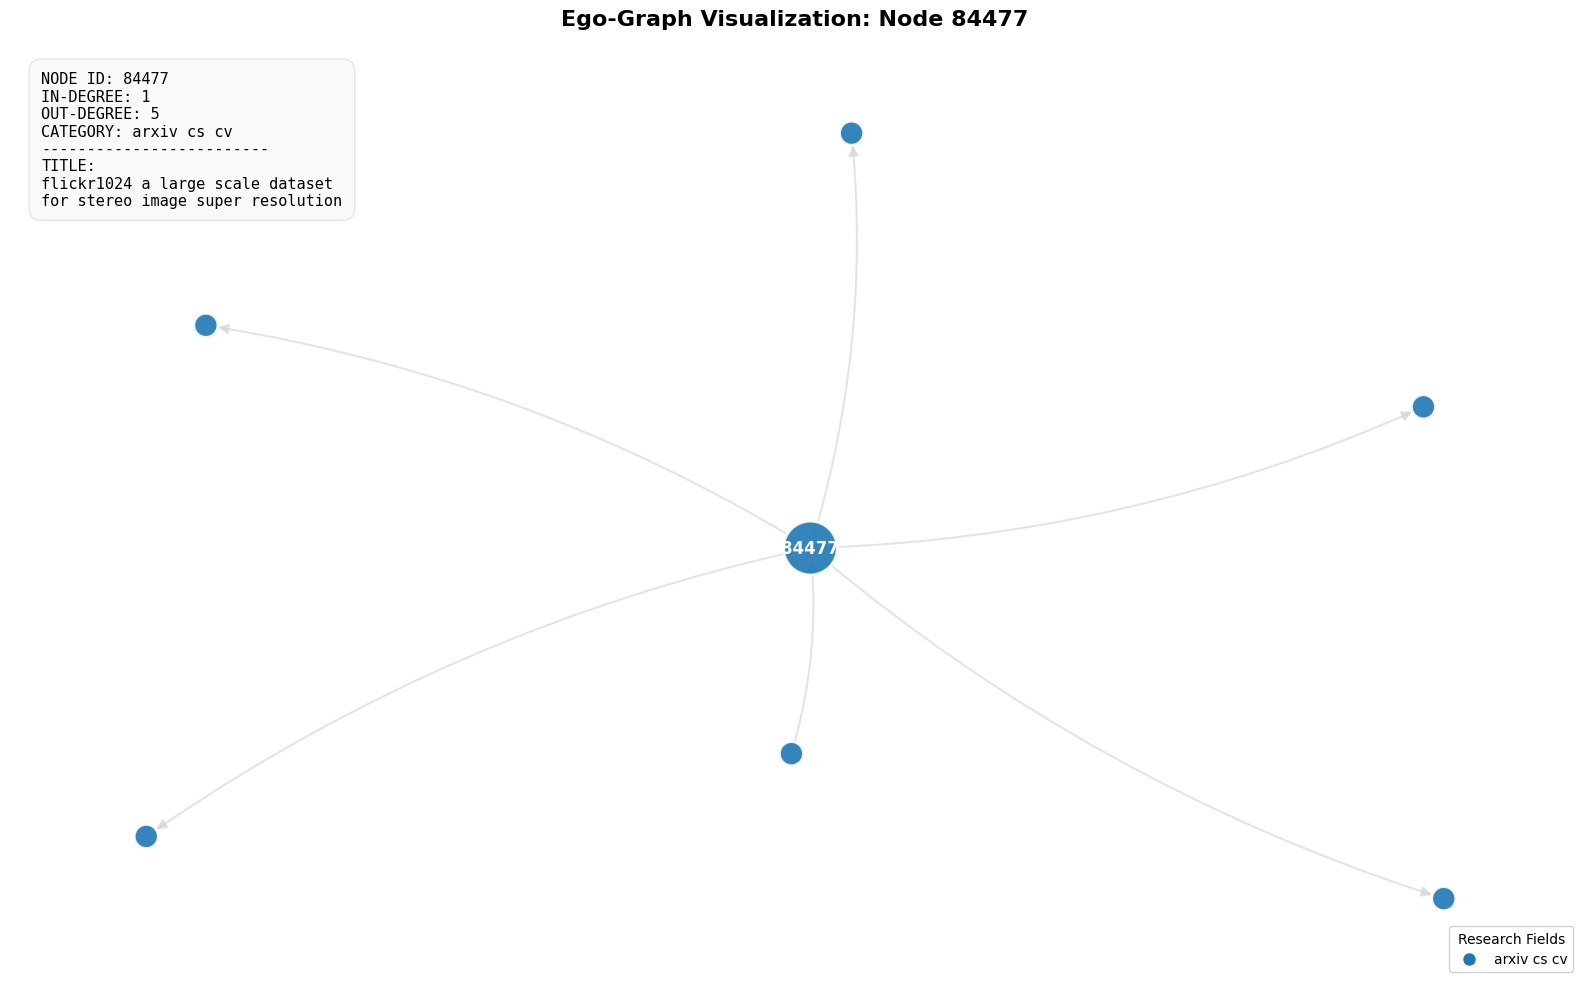

In [15]:
# --- 1. Calculate In-Degrees for all nodes ---
src, dst = edge_index[0], edge_index[1]

# unique_dst: Node IDs that receive at least one citation
# counts: How many citations they received
unique_dst, counts = np.unique(dst, return_counts=True)

# --- 2. Sort and Select Targets ---
# argsort returns the indices that would sort the array
sorted_indices = np.argsort(counts)

# Top 3 Nodes (Highest In-Degree)
# We take the last 3 indices and reverse them to have: 1st, 2nd, 3rd
top_3_indices = sorted_indices[-3:][::-1]
top_3_nodes = unique_dst[top_3_indices]
top_3_counts = counts[top_3_indices]

# Bottom 1 Node (Lowest In-Degree among cited papers)
# We take the first index (usually has 1 citation)
bottom_index = sorted_indices[0]
bottom_node = unique_dst[bottom_index]
bottom_count = counts[bottom_index]

# --- 3. Execute Visualization Loop ---

print(f"--- Selection Summary ---")
print(f"Top 3 Most Cited Nodes: {top_3_nodes} (Citations: {top_3_counts})")
print(f"Least Cited Node: {bottom_node} (Citations: {bottom_count})")
print(f"-------------------------\n")

# List of targets to visualize
targets = list(top_3_nodes) + [bottom_node]
descriptions = ["#1 Most Cited", "#2 Most Cited", "#3 Most Cited", "Least Cited (Example)"]

for node_id, desc in zip(targets, descriptions):
    print(f"Generating Graph for Node {node_id} ({desc})...")
    
    visualize_ego_graph(
        target_node_id=node_id, 
        edge_index=edge_index, 
        labels=labels, 
        label_map=label_map, 
        node2paperid=node2paperid, 
        paperid2title=paperid2title,
        max_nodes=100 
    )

In [16]:
def visualize_complete_interactive(target_node_id, edge_index, labels, label_map, 
                                   node2paperid, paperid2title, max_nodes=40):
    """
    Generates an interactive Plotly visualization for the ego-graph of a specific node.
    Features:
    - Directed edges with arrows.
    - Nodes colored by subject category.
    - Hover tooltips with metadata (ID, Category, Title).
    - Dynamic title showing the paper name.
    """
    
    # --- 1. Data Preparation ---
    src, dst = edge_index[0], edge_index[1]
    
    # Calculate degrees (for display info)
    in_degree = np.sum(dst == target_node_id)
    out_degree = np.sum(src == target_node_id)
    
    # Identify direct neighbors (source or destination is the target)
    neighbor_mask = (src == target_node_id) | (dst == target_node_id)
    direct_neighbors = np.unique(np.concatenate((src[neighbor_mask], dst[neighbor_mask])))
    
    # Remove the target node itself from the neighbor list
    direct_neighbors = direct_neighbors[direct_neighbors != target_node_id]
    
    # Sampling (if too many neighbors, pick a random subset to avoid clutter)
    if len(direct_neighbors) > (max_nodes - 1):
        rng = np.random.default_rng(42)
        direct_neighbors = rng.choice(direct_neighbors, size=(max_nodes - 1), replace=False)

    # Combine target and sampled neighbors
    nodes_in_subgraph = np.append(direct_neighbors, target_node_id)
    
    # IMPORTANT: Filter ALL edges connecting ANY nodes within this subgraph
    # This ensures connections between neighbors (A -> B) are shown, not just A -> Center
    mask_sub = np.isin(src, nodes_in_subgraph) & np.isin(dst, nodes_in_subgraph)
    subset_src = src[mask_sub]
    subset_dst = dst[mask_sub]

    # Create NetworkX Graph (used for layout calculation)
    G = nx.DiGraph()
    G.add_nodes_from(nodes_in_subgraph)
    G.add_edges_from(list(zip(subset_src, subset_dst)))
    
    # Calculate Layout (X, Y positions)
    # 'k' controls the distance between nodes; higher k = more spread out
    pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)

    # --- 2. Target Node Metadata (For the Chart Title) ---
    try:
        center_mag_id = node2paperid[target_node_id]
        center_title_full = paperid2title.get(center_mag_id, "Title not found")
    except KeyError:
        center_title_full = "Metadata not found"
    
    # Truncate title for the chart header if it's too long
    short_title = textwrap.shorten(center_title_full, width=60, placeholder="...")

    # --- 3. Visual Construction ---

    # A. Edge Trace (The lines themselves)
    # We draw the lines explicitly so they appear even if annotations fail
    edge_x = []
    edge_y = []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x.extend([x0, x1, None]) # None adds a break in the line
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.8, color='#888888'), # Thin gray line
        hoverinfo='none',
        mode='lines'
    )

    # B. Annotations (Arrows)
    # Plotly doesn't do directed lines easily, so we add annotations on top of the lines
    annotations = []
    for source, target in G.edges():
        x0, y0 = pos[source]
        x1, y1 = pos[target]
        annotations.append(dict(
            ax=x0, ay=y0, axref='x', ayref='y', # Tail coordinates
            x=x1, y=y1, xref='x', yref='y',     # Head coordinates
            showarrow=True,
            arrowhead=2, 
            arrowsize=1,
            arrowwidth=0.8,
            arrowcolor='#666666',
            opacity=0.6
        ))

    # C. Nodes (Markers)
    node_x, node_y, node_text = [], [], []
    node_bg_color = []
    node_size = []
    line_width, line_color = [], []

    # Color setup: Map categories to a distinct color palette
    unique_labels_in_subgraph = np.unique(labels[nodes_in_subgraph])
    palette = px.colors.qualitative.Dark24 # High contrast palette
    category_to_color = {lbl: palette[i % len(palette)] for i, lbl in enumerate(unique_labels_in_subgraph)}

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        
        # Retrieve Metadata for Hover
        try:
            mag_id = node2paperid[node]
            title = paperid2title.get(mag_id, "Title not found")
        except KeyError:
            title = "Metadata not found"
        
        # Wrap long titles for the tooltip
        wrapped_title = "<br>".join(textwrap.wrap(title, width=50))
        cat_idx = labels[node].item()
        category_name = label_map[cat_idx]
        
        # HTML Tooltip content
        # Using underscores as a separator because <hr> acts weird in some Plotly renderers
        info = (f"<b>ID:</b> {node} | <b>Cat:</b> {category_name}<br>"
                f"________________________________<br>" 
                f"{wrapped_title}")
        node_text.append(info)
        
        # Styling based on node type
        color = category_to_color[cat_idx]
        
        if node == target_node_id:
            # Center Node: Bigger, thick black border
            node_bg_color.append(color) 
            node_size.append(35) 
            line_width.append(3)
            line_color.append('black')
        else:
            # Neighbor Nodes: Smaller, white border
            node_bg_color.append(color)
            node_size.append(15)
            line_width.append(1)
            line_color.append('white')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            color=node_bg_color,
            size=node_size,
            line=dict(width=line_width, color=line_color),
            opacity=1
        )
    )

    # --- 4. Final Figure Assembly ---
    fig = go.Figure(data=[edge_trace, node_trace], # Order matters: edges behind, nodes in front
             layout=go.Layout(
                # Dynamic Title
                title=dict(
                    text=f"<b>{short_title}</b><br>" \
                         f"<span style='font-size:14px;color:grey'>Node ID: {target_node_id} | In-Degree: {in_degree} | Out-Degree: {out_degree}</span>",
                    x=0.05, 
                    y=0.95,
                    font=dict(size=18)
                ),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=20,r=20,t=90), # Top margin increased for title
                annotations=annotations, 
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                plot_bgcolor='white'
             ))

    fig.show()

In [17]:
# --- 1. Calculate In-Degrees for all nodes ---
src, dst = edge_index[0], edge_index[1]

# unique_dst: Node IDs that receive at least one citation
# counts: How many citations they received
unique_dst, counts = np.unique(dst, return_counts=True)

# --- 2. Sort and Select Targets ---
# argsort returns the indices that would sort the array
sorted_indices = np.argsort(counts)

# Top 3 Nodes (Highest In-Degree)
# We take the last 3 indices and reverse them to have: 1st, 2nd, 3rd
top_3_indices = sorted_indices[-3:][::-1]
top_3_nodes = unique_dst[top_3_indices]
top_3_counts = counts[top_3_indices]

# Bottom 1 Node (Lowest In-Degree among cited papers)
# We take the first index (usually has 1 citation)
bottom_index = sorted_indices[0]
bottom_node = unique_dst[bottom_index]
bottom_count = counts[bottom_index]

# --- 3. Execute Visualization Loop ---

print(f"--- Selection Summary ---")
print(f"Top 3 Most Cited Nodes: {top_3_nodes} (Citations: {top_3_counts})")
print(f"Least Cited Node: {bottom_node} (Citations: {bottom_count})")
print(f"-------------------------\n")

# List of targets to visualize
targets = list(top_3_nodes) + [bottom_node]
descriptions = ["#1 Most Cited", "#2 Most Cited", "#3 Most Cited", "Least Cited (Example)"]

for node_id, desc in zip(targets, descriptions):
    print(f"Generating Graph for Node {node_id} ({desc})...")
    
    visualize_complete_interactive(
        target_node_id=node_id, 
        edge_index=edge_index, 
        labels=labels, 
        label_map=label_map, 
        node2paperid=node2paperid, 
        paperid2title=paperid2title,
        max_nodes=40 # You can adjust this if the top nodes are too cluttered
    )

--- Selection Summary ---
Top 3 Most Cited Nodes: [ 1353 67166 25208] (Citations: [13155 12527  9244])
Least Cited Node: 84477 (Citations: 1)
-------------------------

Generating Graph for Node 1353 (#1 Most Cited)...


Generating Graph for Node 67166 (#2 Most Cited)...


Generating Graph for Node 25208 (#3 Most Cited)...


Generating Graph for Node 84477 (Least Cited (Example))...
